In [16]:
from pathlib import Path
import json
import numpy as np
import os
from scipy.signal import butter, lfilter
import time
from subprocess import Popen, PIPE
import shlex
import fire
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy.interpolate import interp1d
import math
import pandas as pd
import glob
from scipy.stats import zscore
import sys

In [17]:
def read_respiratory_trace(bids_physio_file, column=None):
    # Read in physio file and extract only the physio data
    if column is None:
        if "tsv.gz" in bids_physio_file:
            physio_json = bids_physio_file.replace("tsv.gz", "json")
        elif "tsv" in bids_physio_file:
            physio_json = bids_physio_file.replace("tsv", "json")
        else:
            raise ValueError("the physio file must be a tsv or tsv.gz file")
        # read physio json
        with open(physio_json) as f:
            metadata = json.load(f)
        # get respiratory index
        resp_index = metadata["Columns"].index("respiratory")
    else:
        # just set index as column value
        resp_index = int(column)
    # read physio data
    physio_data = np.genfromtxt(bids_physio_file)
    # return column of respiratory trace
    return physio_data[:, resp_index]


def extract_max_freq(resp_trace, sampling_rate):
    fourier_transform = np.fft.rfft(resp_trace)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, sampling_rate / 2, len(power_spectrum))
    assert len(power_spectrum) == len(frequency)
    return frequency[np.argmax(power_spectrum)]


def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    print(low, high, nyq)
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def filter_frequency(data, fs):
    return butter_bandpass_filter(data, 0.05, 1, fs)


def write_output(output_folder, physio_path, data):
    out = Path(output_folder)
    if not out.is_dir():
        raise FileNotFoundError("output directory is not found")
    outname = "{}.1D".format(os.path.basename(physio_path).split(".")[0])
    np.savetxt(str(out / outname), data, fmt="%.06f")
    return str(out / outname)


def process_physio(physio_path, output_dir, fs):
    rt = read_respiratory_trace(physio_path, column=2)
    # demean rt
    rt = rt - np.mean(rt)
    max_freq = extract_max_freq(rt, fs)
    if (max_freq > 0.15) and (max_freq < 1):
        filtered = filter_frequency(rt, fs)
        # extract_max_freq(filtered, 62.5)
        return write_output(output_dir, physio_path, filtered)
    else:
        return None


def make_retroicor_string(nifti_image, physio_path, output_dir):
    new_nifti_name = "{}_retroicor.nii.gz".format(
        os.path.basename(nifti_image).split(".")[0]
    )
    output_dir = Path(output_dir).resolve()
    return "3dretroicor -prefix {} -resp {} {}".format(
        output_dir / new_nifti_name, physio_path, nifti_image
    )


def print_cmd(cmd_str):
    print(cmd_str.replace(" -", "\n -"))


def run_cmd(cmd):
    start_time = time.time()
    print_cmd(cmd)
    p = Popen(shlex.split(cmd), stdout=PIPE, stderr=PIPE)
    stdout, stderr = p.communicate()
    print("Elapsed time: {:.2f}s".format(time.time() - start_time))


def run(nifti_image, physio_path, output_dir, fs):
    processed_physio_path = process_physio(physio_path, output_dir, fs)
    if processed_physio_path is None:
        print("{}: bad physio file".format(physio_path))
        return
    # resolve full physio_path
    processed_physio_path = Path(processed_physio_path).resolve()
    retroicor_str = make_retroicor_string(
        nifti_image, processed_physio_path, output_dir
    )
    print(retroicor_str)
    run_cmd(retroicor_str)

# Read in and plot raw trace

In [18]:
rt = read_respiratory_trace('sub-02_ses-movie_task-movie_run-1_recording-cardresp_physio.tsv.gz', column = 2)

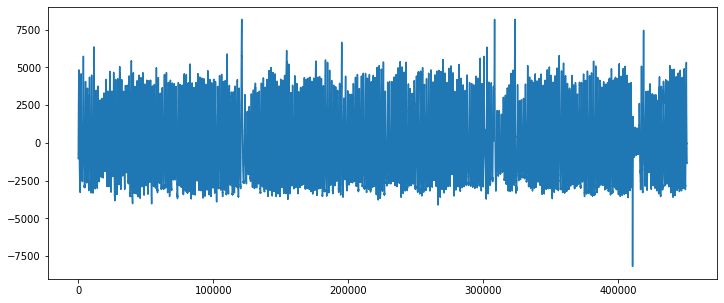

In [19]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.plot(rt)

# Filter and plot 

tell it the sampling frequency is 500hz

In [20]:
fs = 500
rt = rt - np.mean(rt)
max_freq = extract_max_freq(rt, fs)

In [21]:
filtered = filter_frequency(rt, fs)

0.0002 0.004 250.0


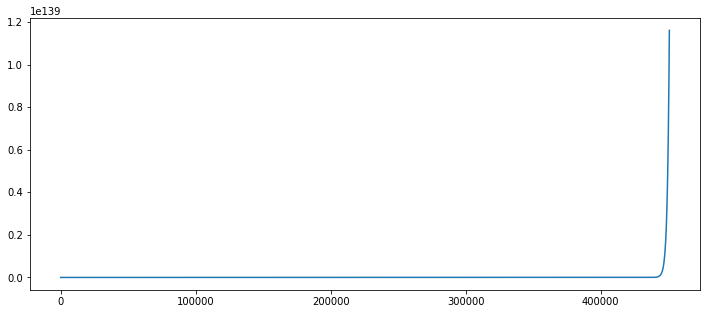

In [22]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.plot(filtered)


# Filter and plot with a lower input sampling frequency

0.00025 0.005 200.0


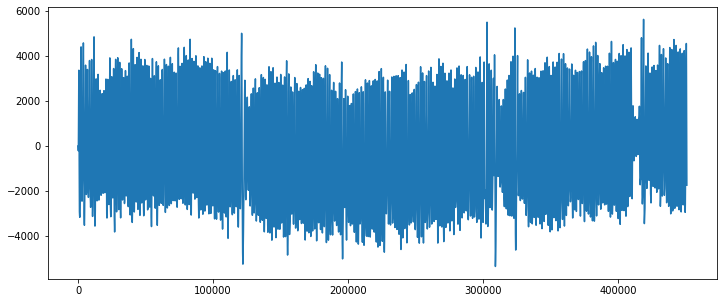

In [23]:
fs = 400
rt = rt - np.mean(rt)
max_freq = extract_max_freq(rt, fs)
filtered = filter_frequency(rt, fs)
plt.rcParams['figure.figsize'] = [12, 5]
plt.plot(filtered)


In [24]:
def get_motion_freq(raw_data, tr, scan_id, max_tr_num):
	half_max_num = math.ceil(max_tr_num/2)
	sampling_rate = 1/tr

	# get the frequencies to use for the reference
	full_freqs = (fftfreq(max_tr_num) * sampling_rate)[0:half_max_num]

	# set up size of output matrix
	freq_mat = np.zeros(half_max_num)

	# generate spectra for each of the 6 parameters
	for i in range(6):
		# generate the fft and raw frequencies
		fft_init = (fft(raw_data))[0:math.ceil(raw_data.shape[0]/2)]
		raw_freqs = (fftfreq(raw_data.shape[0]) * sampling_rate)[0:math.ceil(raw_data.shape[0]/2)]

		# if number of trs in scan is not equal to the reference number of TRs, interpolate
		# save the absolute value at each frequency
		if raw_data.shape[0] != max_tr_num:
			upsample_func = interp1d(raw_freqs, fft_init, fill_value = 'extrapolate')
			freq_mat = np.abs(upsample_func(full_freqs))
		else:
			freq_mat = np.abs(fft_init[0:half_max_num])

	# output scan-specific DataFrame
	df = pd.DataFrame(freq_mat)
	df['frequency'] = full_freqs
	df = df[df.frequency >= 0]
	df['scan_id'] = scan_id
	return(df)

In [35]:
a= get_motion_freq(raw_data = rt, tr = 1/500, scan_id= 'test', max_tr_num = 451000)

In [47]:
out_df_list = []
max_tr_num = 200000
files = glob.glob('*tsv.gz')
print(files)


['sub-09_ses-movie_task-movie_run-6_recording-cardresp_physio.tsv.gz', 'sub-15_ses-movie_task-movie_run-3_recording-cardresp_physio.tsv.gz', 'sub-02_ses-movie_task-movie_run-3_recording-cardresp_physio.tsv.gz', 'sub-04_ses-movie_task-movie_run-5_recording-cardresp_physio.tsv.gz', 'sub-10_ses-movie_task-movie_run-6_recording-cardresp_physio.tsv.gz', 'sub-04_ses-movie_task-movie_run-1_recording-cardresp_physio.tsv.gz', 'sub-10_ses-movie_task-movie_run-2_recording-cardresp_physio.tsv.gz', 'sub-18_ses-movie_task-movie_run-4_recording-cardresp_physio.tsv.gz', 'sub-15_ses-movie_task-movie_run-7_recording-cardresp_physio.tsv.gz', 'sub-09_ses-movie_task-movie_run-2_recording-cardresp_physio.tsv.gz', 'sub-16_ses-movie_task-movie_run-4_recording-cardresp_physio.tsv.gz', 'sub-02_ses-movie_task-movie_run-7_recording-cardresp_physio.tsv.gz', 'sub-03_ses-movie_task-movie_run-8_recording-cardresp_physio.tsv.gz', 'sub-14_ses-movie_task-movie_run-8_recording-cardresp_physio.tsv.gz', 'sub-20_ses-movie_t

In [53]:
for index, file in enumerate(files):
    print(index)
    raw = read_respiratory_trace(file, column = 2)
    # get the motion power spectra for 1 scan
    motion_power_spectra = get_motion_freq(raw_data= raw, tr = 1/500, scan_id = file.split('/')[-1], max_tr_num = max_tr_num)
    # add median fd to scan (for ranking)
    motion_power_spectra['num_tr'] = raw.shape[0]
    out_df_list.append(motion_power_spectra)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111


In [54]:
combined_df = pd.concat(out_df_list)

In [59]:
combined_df.head()

KeyboardInterrupt: 

In [63]:
filt = combined_df[combined_df.frequency <= 2]
filt.to_csv('respiration_freqs.csv', index = False)